Epoch [0/50] Loss: 0.0325
Epoch [1/50] Loss: 0.0206
Epoch [2/50] Loss: 0.0176
Epoch [3/50] Loss: 0.0156
Epoch [4/50] Loss: 0.0140
Epoch [5/50] Loss: 0.0136
Epoch [6/50] Loss: 0.0129
Epoch [7/50] Loss: 0.0124
Epoch [8/50] Loss: 0.0120
Epoch [9/50] Loss: 0.0116
Epoch [10/50] Loss: 0.0114
Epoch [11/50] Loss: 0.0112
Epoch [12/50] Loss: 0.0107
Epoch [13/50] Loss: 0.0107
Epoch [14/50] Loss: 0.0103
Epoch [15/50] Loss: 0.0102
Epoch [16/50] Loss: 0.0101
Epoch [17/50] Loss: 0.0099
Epoch [18/50] Loss: 0.0099
Epoch [19/50] Loss: 0.0099
Epoch [20/50] Loss: 0.0097
Epoch [21/50] Loss: 0.0095
Epoch [22/50] Loss: 0.0094
Epoch [23/50] Loss: 0.0093
Epoch [24/50] Loss: 0.0092
Epoch [25/50] Loss: 0.0092
Epoch [26/50] Loss: 0.0092
Epoch [27/50] Loss: 0.0091
Epoch [28/50] Loss: 0.0091
Epoch [29/50] Loss: 0.0089
Epoch [30/50] Loss: 0.0089
Epoch [31/50] Loss: 0.0087
Epoch [32/50] Loss: 0.0088
Epoch [33/50] Loss: 0.0087
Epoch [34/50] Loss: 0.0086
Epoch [35/50] Loss: 0.0086
Epoch [36/50] Loss: 0.0087
Epoch [37/5

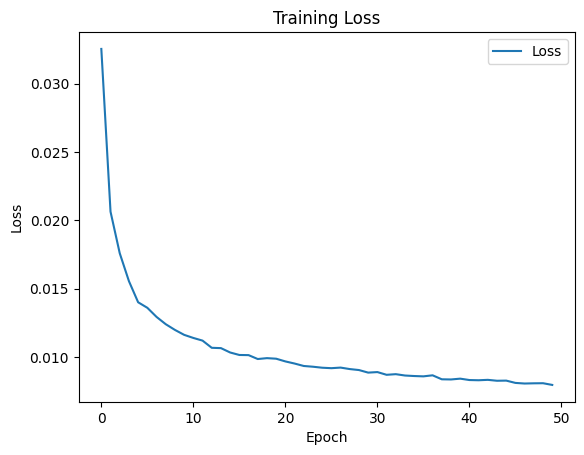

FileNotFoundError: [Errno 2] No such file or directory: '/home/lab/hnakai/Graduation-Thesis/counterfactuals/output/reconstructed_pair_0.png'

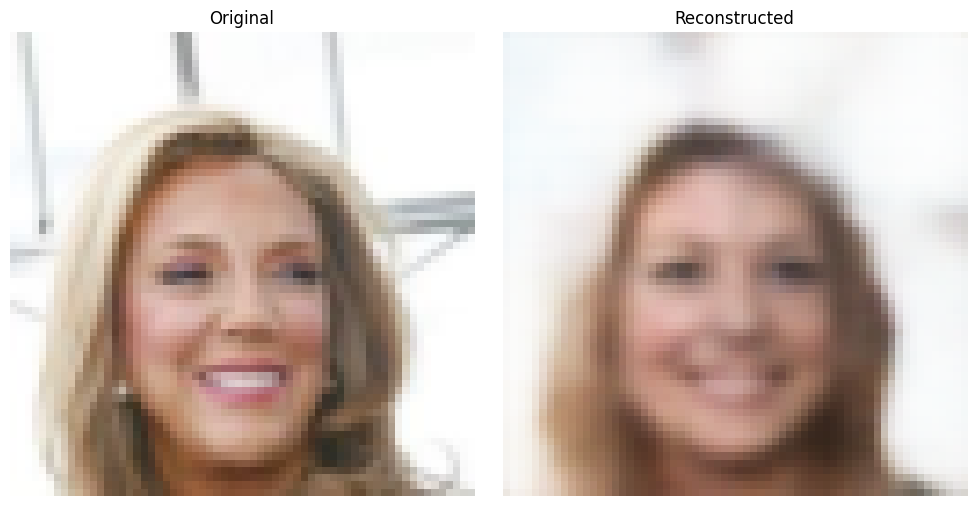

In [5]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random
from typing import List, Tuple  # ここで List と Tuple をインポート

class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.dataset = ImageFolder(root=root_dir, transform=transform)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx][0]

class VAE_CelebA(nn.Module):
    def __init__(self, in_channels: int, latent_dim: int = 128, hidden_dims: List = None):
        super(VAE_CelebA, self).__init__()
        self.latent_dim = latent_dim

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.feature_size = self._get_feature_size(64)
        self.fc_mu = nn.Linear(self.feature_size, latent_dim)
        self.fc_var = nn.Linear(self.feature_size, latent_dim)

        modules = []
        self.decoder_input = nn.Linear(latent_dim, self.feature_size)
        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride=2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(hidden_dims[-1],
                               hidden_dims[-1],
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.BatchNorm2d(hidden_dims[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_dims[-1], out_channels=3,
                      kernel_size=3, padding=1),
            nn.Tanh())

    def _get_feature_size(self, img_size):
        x = torch.zeros(1, 3, img_size, img_size)
        x = self.encoder(x)
        return x.view(1, -1).size(1)

    def encode(self, input: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        return mu, log_var

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        result = (result + 1.) / 2.
        return result

    def forward(self, input: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), input, mu, log_var

    def loss_function(self,
                      recons: torch.Tensor, 
                      input: torch.Tensor, 
                      mu: torch.Tensor, 
                      log_var: torch.Tensor, 
                      kld_weight: float = 0.00001) -> torch.Tensor:
        recons_loss = F.mse_loss(recons, input)
        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim=1), dim=0)
        loss = recons_loss + kld_weight * kld_loss
        return loss

IMAGE_SIZE = 64
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE, antialias=True),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor()
])

data_dir = '/home/data/hnakai/CelebA'
dataset = CelebADataset(root_dir=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = VAE_CelebA(in_channels=3, latent_dim=128).to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

num_epochs = 50
model.train()
epoch_losses = []

for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_idx, images in enumerate(dataloader):
        images = images.to(device)
        optimizer.zero_grad()
        recons, input, mu, log_var = model(images)
        loss = model.loss_function(recons, input, mu, log_var)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_losses.append(epoch_loss / len(dataloader))
    print(f'Epoch [{epoch}/{num_epochs}] Loss: {epoch_losses[-1]:.4f}')

torch.save({
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'epoch': num_epochs,
    'loss': epoch_losses,
}, 'checkpoints/generative_models/CelebA_cVAE.pth')

plt.figure()
plt.plot(range(num_epochs), epoch_losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# モデルの評価と画像の表示
model.eval()
with torch.no_grad():
    random_indices = random.sample(range(len(dataset)), 10)
    random_samples = [dataset[i] for i in random_indices]
    random_samples_tensor = torch.stack(random_samples).to(device)
    
    recons, _, _, _ = model(random_samples_tensor)
    
    # 元の画像と再構成画像を並べて表示
    fig, axes = plt.subplots(5, 2, figsize=(10, 20))
    for i in range(5):
        original_img = transforms.ToPILImage()(random_samples_tensor[i].cpu())
        recons_img = transforms.ToPILImage()(recons[i].cpu())
        
        axes[i, 0].imshow(original_img)
        axes[i, 0].set_title("Original")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(recons_img)
        axes[i, 1].set_title("Reconstructed")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()